### **Analyzing Latency for Elevance DigitalOpenAI-Prod where RatelimitKey equals 'deployments.gpt-4-613-ptu-beca-v2' from Thu Jun 06 2024 14:48:30 GMT-0500 (Central Daylight Time) to Fri Jun 07 2024 14:48:30 GMT-0500 (Central Daylight Time).**

📝 **Agenda:**

1. Compute and examine average metrics such as 'Avg Generated Completion Tokens', 'Avg Processed Prompt Tokens', and 'Latency'.
2. Calculate the Interquartile Range (IQR) and range (min to max) for these metrics.
3. Generate a correlation matrix to understand the relationships between these metrics.
4. Identify and analyze outliers in 'Avg Generated Completion Tokens' and 'Avg Processed Prompt Tokens'.
5. Perform linear regression for 'Avg Generated Completion Tokens' and 'Avg Processed Prompt Tokens' against 'Latency' and calculate residuals.
6. Visualization of Relationships and Outliers. Explore instances where significant variations in latency times occur, despite the similarity in input and generation prompt tokens.
7. Discuss the findings and their implications.

## Loading Data

In [1]:
import pandas as pd

file_path = 'C:\\Users\\pablosal\\Desktop\\gbbai-azure-openai-benchmark\\utils\\BeCA_PTU_Managed_Metrics_test.xlsx'

try:
    xls = pd.ExcelFile(file_path, engine='openpyxl')
except FileNotFoundError:
    print(f"File not found: {file_path}")
except ValueError as e:
    print(f"Value error occurred: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
else:
    merged_df = pd.DataFrame()
    for sheet_name in xls.sheet_names:
        try:
            df = pd.read_excel(xls, sheet_name=sheet_name, engine='openpyxl')
            if 'time' not in df.columns:
                print(f"Skipping sheet '{sheet_name}' because it does not contain a 'time' column.")
                continue
            if merged_df.empty:
                merged_df = df
            else:
                merged_df = pd.merge(merged_df, df, on='time', how='left')
        except Exception as e:
            print(f"An error occurred while processing sheet '{sheet_name}': {e}")

    if not merged_df.empty:
        try:
            merged_df.to_excel('merged_output.xlsx', index=False)
        except Exception as e:
            print(f"An error occurred while writing to 'merged_output.xlsx': {e}")
    else:
        print("No data to write to 'merged_output.xlsx'.")

In [2]:
columns = ['DigitalOpenAI-Prod, Generated Completion Tokens (Sum), DigitalOpenAI-Prod',
           'DigitalOpenAI-Prod, Processed Inference Tokens (Sum), DigitalOpenAI-Prod',
           'DigitalOpenAI-Prod, Processed Prompt Tokens (Sum), DigitalOpenAI-Prod',
           'DigitalOpenAI-Prod, Successful Calls (Sum), DigitalOpenAI-Prod',
           'DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod']

if isinstance(merged_df, pd.DataFrame) and all(col in merged_df.columns for col in columns):
    successful_calls = merged_df['DigitalOpenAI-Prod, Successful Calls (Sum), DigitalOpenAI-Prod']
    if successful_calls.eq(0).any():
        print("Warning: 'Successful Calls' contains zero values. Division by zero will result in infinity.")
    merged_df['Avg Generated Completion Tokens'] = merged_df['DigitalOpenAI-Prod, Generated Completion Tokens (Sum), DigitalOpenAI-Prod'] / successful_calls
    merged_df['Avg Processed Inference Tokens'] = merged_df['DigitalOpenAI-Prod, Processed Inference Tokens (Sum), DigitalOpenAI-Prod'] / successful_calls
    merged_df['Avg Processed Prompt Tokens'] = merged_df['DigitalOpenAI-Prod, Processed Prompt Tokens (Sum), DigitalOpenAI-Prod'] / successful_calls
    merged_df['DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod'] = merged_df['DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod'] / 1000
else:
    print("Error: DataFrame or required columns are missing.")

In [3]:
merged_df.head()

,time,"DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Total Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Successful Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Generated Completion Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Inference Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Prompt Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Provisioned-managed Utilization V2 (Avg), DigitalOpenAI-Prod",Avg Generated Completion Tokens,Avg Processed Inference Tokens,Avg Processed Prompt Tokens
0,2024-06-06 14:49:00,4.562667,3,3,339,3662,3323,3.047778,113.0,1220.666667,1107.666667
1,2024-06-06 14:50:00,3.633000,2,2,161,964,803,0.845315,80.5,482.000000,401.500000
2,2024-06-06 14:51:00,2.448000,1,1,71,481,410,0.361014,71.0,481.000000,410.000000
3,2024-06-06 14:52:00,2.268000,1,1,69,491,422,0.365818,69.0,491.000000,422.000000
4,2024-06-06 14:53:00,2.838000,2,2,145,1252,1107,0.943806,72.5,626.000000,553.500000


## Analysis of Averages

In [4]:
if isinstance(merged_df, pd.DataFrame) and 'time' in merged_df.columns:
    summary = merged_df.drop('time', axis=1).describe(percentiles=[.1, .25, .5, .75, .9, .95, .99])
    display(summary)
else:
    print("Error: DataFrame or 'time' column is missing.")

,"DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Total Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Successful Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Generated Completion Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Inference Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Prompt Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Provisioned-managed Utilization V2 (Avg), DigitalOpenAI-Prod",Avg Generated Completion Tokens,Avg Processed Inference Tokens,Avg Processed Prompt Tokens
count,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000
mean,5.148420,1.681440,1.681440,199.130194,1901.404432,1702.274238,1.608881,121.567613,1136.374538,1014.806925
std,1.940789,1.080594,1.080594,125.032783,1502.519206,1398.332129,1.218081,36.968746,545.419848,528.681784
min,1.209000,1.000000,1.000000,31.000000,392.000000,326.000000,0.240428,31.000000,392.000000,326.000000
10%,3.308000,1.000000,1.000000,91.000000,550.000000,450.000000,0.509677,83.000000,530.000000,443.000000
25%,3.946000,1.000000,1.000000,112.000000,876.000000,743.000000,0.774137,99.000000,710.000000,605.000000
50%,4.717000,1.000000,1.000000,149.000000,1389.000000,1234.000000,1.216967,116.500000,1039.000000,905.500000
75%,6.099000,2.000000,2.000000,259.000000,2344.000000,2139.000000,2.025000,141.250000,1405.000000,1275.000000
90%,7.273000,3.000000,3.000000,373.000000,3862.000000,3500.000000,3.177365,163.333333,1944.000000,1814.000000
95%,8.346000,4.000000,4.000000,466.000000,4900.000000,4492.000000,4.064857,182.000000,2225.000000,2074.500000


### Exploring Data Variations and Correlations

In [5]:
columns = ['DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod', 'Avg Generated Completion Tokens', 'Avg Processed Prompt Tokens']

if isinstance(merged_df, pd.DataFrame) and all(col in merged_df.columns for col in columns):
    for col in columns:
        Q1 = merged_df[col].quantile(0.25)
        Q3 = merged_df[col].quantile(0.75)
        IQR = Q3 - Q1
        min_val = merged_df[col].min()
        max_val = merged_df[col].max()
        print(f"Range for {col}: {min_val} to {max_val}")
        print(f"IQR for {col}: {IQR}")

    correlation_matrix = merged_df[columns].corr()
    print("\nCorrelation Matrix:")
    display(correlation_matrix)
else:
    print("Error: DataFrame or required columns are missing.")

Range for DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod: 1.209 to 19.103
IQR for DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod: 2.153
Range for Avg Generated Completion Tokens: 31.0 to 384.0
IQR for Avg Generated Completion Tokens: 42.25
Range for Avg Processed Prompt Tokens: 326.0 to 2679.0
IQR for Avg Processed Prompt Tokens: 670.0

Correlation Matrix:


,"DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod",Avg Generated Completion Tokens,Avg Processed Prompt Tokens
"DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod",1.000000,0.786889,0.391880
Avg Generated Completion Tokens,0.786889,1.000000,0.424967
Avg Processed Prompt Tokens,0.391880,0.424967,1.000000


## Evaluating Performance Metrics by Latency Score Analysis

Top outliers for 'Avg Generated Completion Tokens':


,time,"DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Total Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Successful Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Generated Completion Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Inference Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Prompt Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Provisioned-managed Utilization V2 (Avg), DigitalOpenAI-Prod",Avg Generated Completion Tokens,Avg Processed Inference Tokens,Avg Processed Prompt Tokens,Residuals Generated Tokens,Residuals Processed Tokens
272,2024-06-07 12:13:00,10.341,1,1,144,1121,977,1.036291,144.0,1121.0,977.0,4.265895,5.246969
197,2024-06-07 09:50:00,11.354,1,1,168,1603,1435,1.447845,168.0,1603.0,1435.0,4.287451,5.601094
246,2024-06-07 11:25:00,10.358,2,2,244,2575,2331,2.283851,122.0,1287.5,1165.5,5.191718,4.992794
35,2024-06-06 15:25:00,11.778,1,1,128,1405,1277,1.145578,128.0,1405.0,1277.0,6.363857,6.252391
48,2024-06-06 15:43:00,19.103,1,1,262,1846,1584,1.661532,262.0,1846.0,1584.0,8.153295,13.135744


Top outliers for 'Avg Processed Prompt Tokens':


,time,"DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Total Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Successful Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Generated Completion Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Inference Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Prompt Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Provisioned-managed Utilization V2 (Avg), DigitalOpenAI-Prod",Avg Generated Completion Tokens,Avg Processed Inference Tokens,Avg Processed Prompt Tokens,Residuals Generated Tokens,Residuals Processed Tokens
299,2024-06-07 13:01:00,12.188,2,2,422,4409,3987,3.795968,211.0,2204.5,1993.5,3.345113,5.631640
35,2024-06-06 15:25:00,11.778,1,1,128,1405,1277,1.145578,128.0,1405.0,1277.0,6.363857,6.252391
73,2024-06-06 16:38:00,12.214,1,1,250,1298,1048,1.227455,250.0,1298.0,1048.0,1.760017,7.017829
314,2024-06-07 13:39:00,12.505,1,1,384,1608,1224,1.741111,384.0,1608.0,1224.0,-3.484545,7.055637
48,2024-06-06 15:43:00,19.103,1,1,262,1846,1584,1.661532,262.0,1846.0,1584.0,8.153295,13.135744


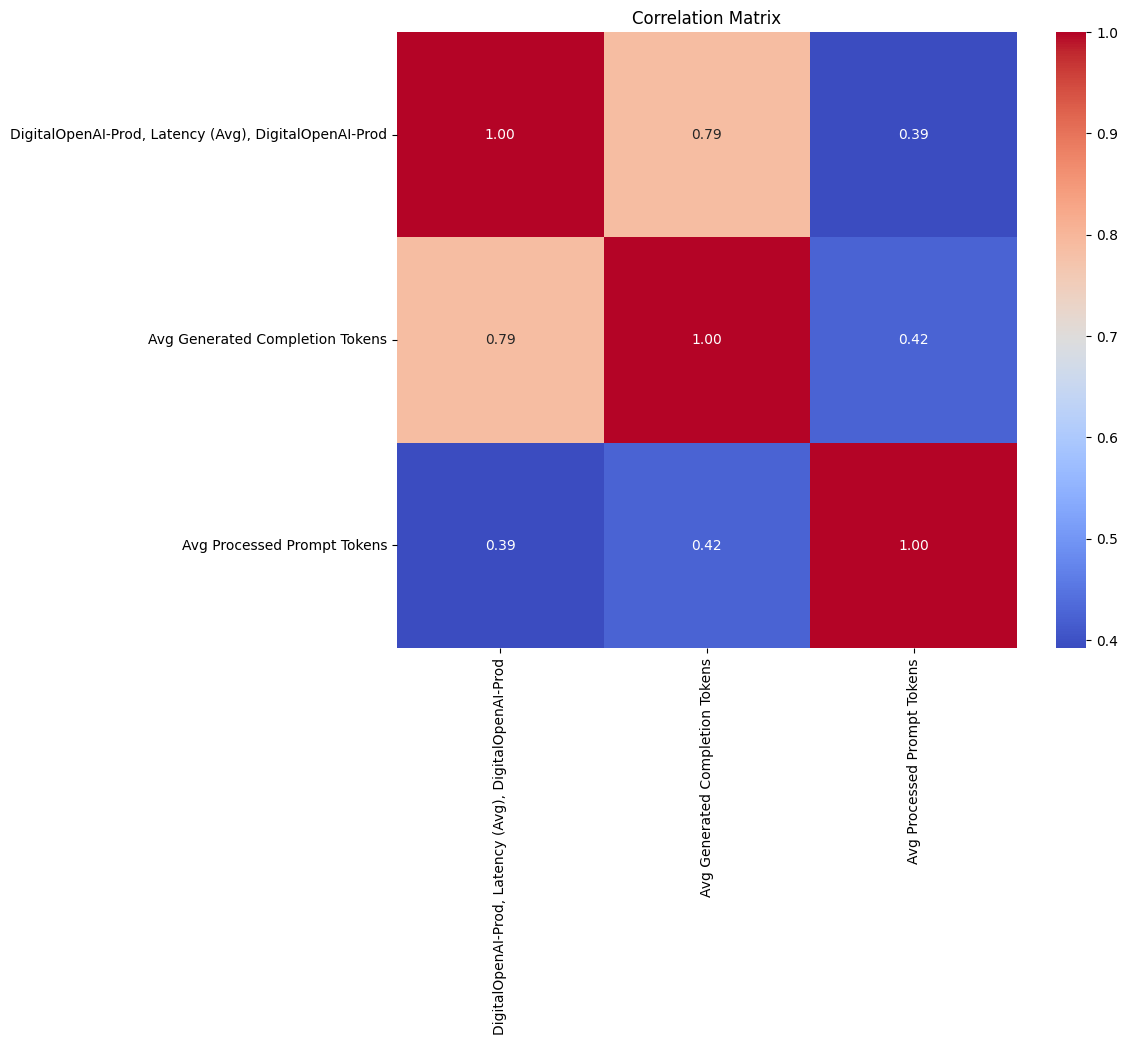

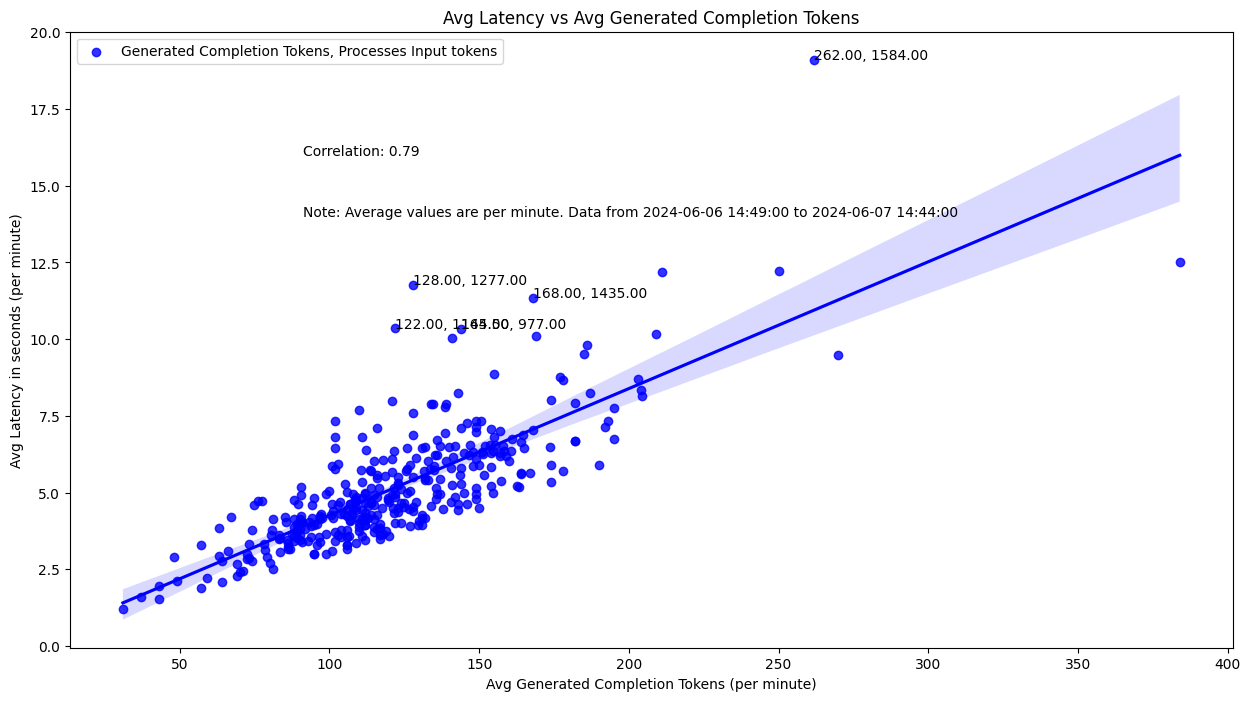

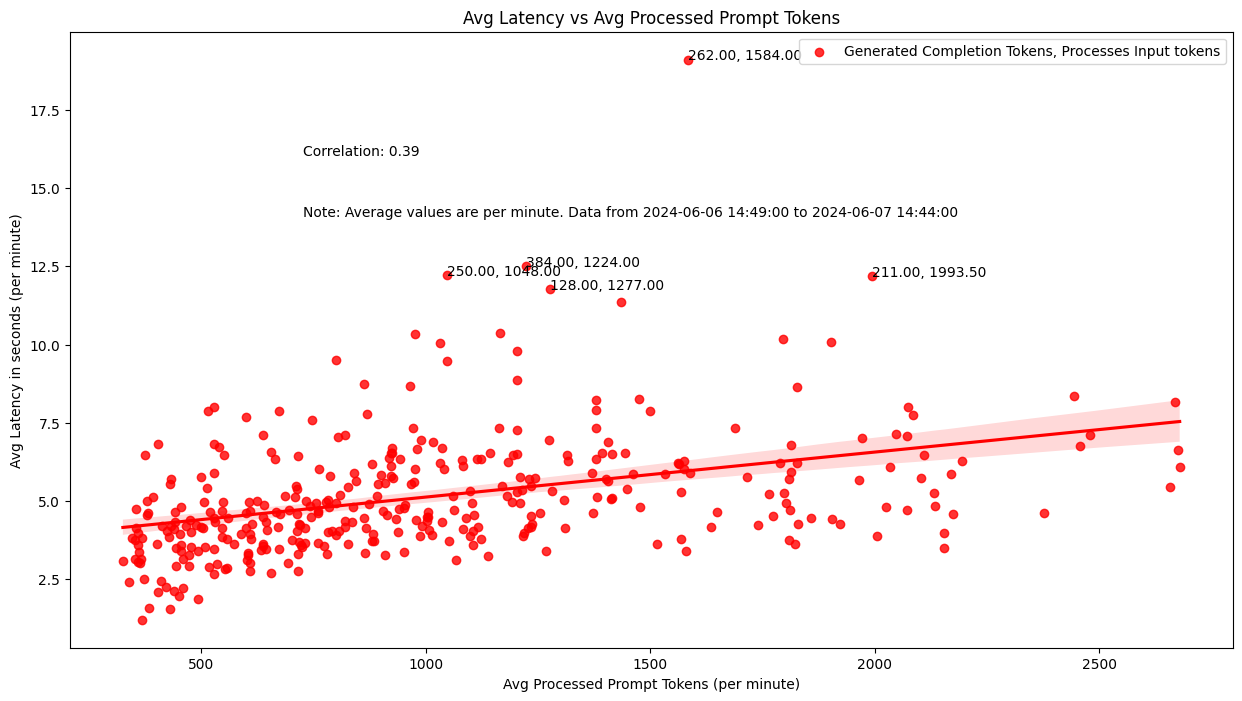

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

correlation_matrix = merged_df[['DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod', 
                                     'Avg Generated Completion Tokens', 
                                     'Avg Processed Prompt Tokens']].corr()

min_time = merged_df['time'].min()
max_time = merged_df['time'].max()

slope, intercept, r_value, p_value, std_err = stats.linregress(merged_df['Avg Generated Completion Tokens'], merged_df['DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod'])
merged_df['Residuals Generated Tokens'] = merged_df['DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod'] - (slope * merged_df['Avg Generated Completion Tokens'] + intercept)

slope, intercept, r_value, p_value, std_err = stats.linregress(merged_df['Avg Processed Prompt Tokens'], merged_df['DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod'])
merged_df['Residuals Processed Tokens'] = merged_df['DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod'] - (slope * merged_df['Avg Processed Prompt Tokens'] + intercept)

top_outliers_generated = merged_df.iloc[np.abs(merged_df['Residuals Generated Tokens']).argsort()[-5:]]
top_outliers_processed = merged_df.iloc[np.abs(merged_df['Residuals Processed Tokens']).argsort()[-5:]]

from IPython.display import display

print("Top outliers for 'Avg Generated Completion Tokens':")
display(top_outliers_generated)

print("Top outliers for 'Avg Processed Prompt Tokens':")
display(top_outliers_processed)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

plt.figure(figsize=(15, 8))
sns.regplot(x='Avg Generated Completion Tokens', 
            y='DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod', 
            data=merged_df, color='blue', label='Generated Completion Tokens, Processes Input tokens')
for i in range(top_outliers_generated.shape[0]):
    plt.annotate(f"{top_outliers_generated.iloc[i]['Avg Generated Completion Tokens']:.2f}, {top_outliers_generated.iloc[i]['Avg Processed Prompt Tokens']:.2f}", 
                 (top_outliers_generated.iloc[i]['Avg Generated Completion Tokens'], top_outliers_generated.iloc[i]['DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod']))
plt.xlabel('Avg Generated Completion Tokens (per minute)')
plt.ylabel('Avg Latency in seconds (per minute)')
plt.title('Avg Latency vs Avg Generated Completion Tokens')
plt.legend()
plt.text(0.2, 0.8, f"Correlation: {correlation_matrix.loc['Avg Generated Completion Tokens', 'DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod']:.2f}", transform=plt.gca().transAxes)
plt.text(0.2, 0.7, f"Note: Average values are per minute. Data from {min_time} to {max_time}", transform=plt.gca().transAxes)
plt.show()

plt.figure(figsize=(15, 8))
sns.regplot(x='Avg Processed Prompt Tokens', 
            y='DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod', 
            data=merged_df, color='red', label='Generated Completion Tokens, Processes Input tokens')
for i in range(top_outliers_processed.shape[0]):
    plt.annotate(f"{top_outliers_processed.iloc[i]['Avg Generated Completion Tokens']:.2f}, {top_outliers_processed.iloc[i]['Avg Processed Prompt Tokens']:.2f}", 
                 (top_outliers_processed.iloc[i]['Avg Processed Prompt Tokens'], top_outliers_processed.iloc[i]['DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod']))
plt.xlabel('Avg Processed Prompt Tokens (per minute)')
plt.ylabel('Avg Latency in seconds (per minute)')
plt.title('Avg Latency vs Avg Processed Prompt Tokens')
plt.legend()
plt.text(0.2, 0.8, f"Correlation: {correlation_matrix.loc['Avg Processed Prompt Tokens', 'DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod']:.2f}", transform=plt.gca().transAxes)
plt.text(0.2, 0.7, f"Note: Average values are per minute. Data from {min_time} to {max_time}", transform=plt.gca().transAxes)
plt.show()

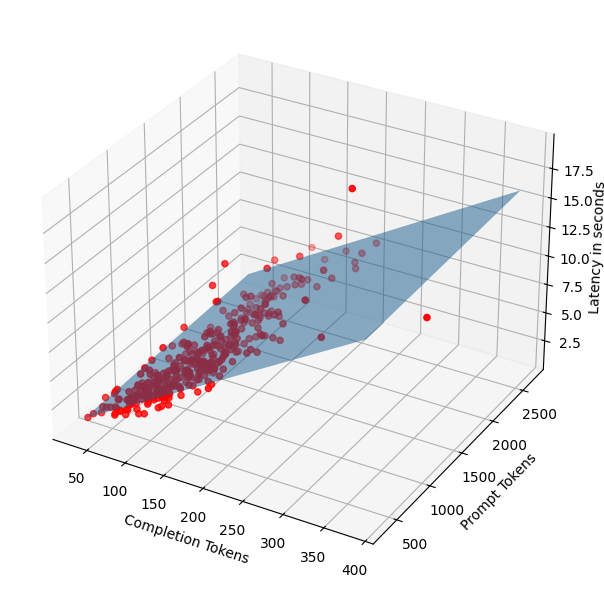

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression

# Reshape the data to fit the model
X = merged_df[['Avg Generated Completion Tokens', 'Avg Processed Prompt Tokens']].values
Y = merged_df['DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod'].values

# Fit the model
model = LinearRegression()
model.fit(X, Y)

# Create a grid of points over which to evaluate the model
x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), num=10)
y_range = np.linspace(X[:, 1].min(), X[:, 1].max(), num=10)
x_grid, y_grid = np.meshgrid(x_range, y_range)
z_grid = model.predict(np.c_[x_grid.ravel(), y_grid.ravel()]).reshape(x_grid.shape)

# Plot the original data and the plane
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], Y, c='r', marker='o')
ax.plot_surface(x_grid, y_grid, z_grid, alpha=0.5, rstride=100, cstride=100)

ax.set_xlabel('Completion Tokens')
ax.set_ylabel('Prompt Tokens')
ax.set_zlabel('Latency in seconds', labelpad=1)

plt.tight_layout()
plt.show()

## Investigating Discrepancies: Similar Token Counts but Varying Latency Times

In [7]:
filtered_df = merged_df[(merged_df['DigitalOpenAI-Prod, Successful Calls (Sum), DigitalOpenAI-Prod'] == 1)]

1. Calculate the Euclidean distance between the tokens to find the most similar numbers.
2. Identify pairs of records with the smallest distance between their token numbers.
3. Calculate the difference in latency for these pairs.
4. Sort the pairs by the difference in latency in descending order.
5. Select the pair with the highest latency difference.

In [95]:
from scipy.spatial import distance
results = []

for i in range(len(filtered_df)):
    for j in range(i+1, len(filtered_df)):
        token_distance = distance.euclidean(
            [filtered_df.iloc[i]['DigitalOpenAI-Prod, Generated Completion Tokens (Sum), DigitalOpenAI-Prod'], filtered_df.iloc[i]['DigitalOpenAI-Prod, Processed Prompt Tokens (Sum), DigitalOpenAI-Prod']],
            [filtered_df.iloc[j]['DigitalOpenAI-Prod, Generated Completion Tokens (Sum), DigitalOpenAI-Prod'], filtered_df.iloc[j]['DigitalOpenAI-Prod, Processed Prompt Tokens (Sum), DigitalOpenAI-Prod']]
        )
        latency_difference = abs(filtered_df.iloc[i]['DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod'] - 
                                 filtered_df.iloc[j]['DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod'])
        
        results.append({
            'Pair': (i, j),
            'Latency Difference': latency_difference,
            'Token Distance': token_distance
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Find the pair with the smallest token distance and highest latency difference
most_disparate_pair = results_df.sort_values(by=['Token Distance', 'Latency Difference'], ascending=[True, False])


In [97]:
most_disparate_pair.head()

,Pair,Latency Difference,Token Distance
4969,"(23, 140)",3.554,0.0
19805,"(123, 126)",2.123,0.0
6159,"(29, 157)",0.876,0.0
5950,"(28, 141)",0.606,0.0
7365,"(36, 40)",1.718,1.0


## Found Disparity

In the analysis below, we will be examining instances where there is a disparity in latency times despite having similar input and generation prompt tokens. 

In [98]:
from IPython.display import display, Markdown

for i in range(min(100, len(most_disparate_pair))): 
    if most_disparate_pair.iloc[i]['Latency Difference'] > 2:
        index1, index2 = most_disparate_pair.iloc[i]['Pair']
        row1 = filtered_df.iloc[index1]
        row2 = filtered_df.iloc[index2]
        pair_df = pd.concat([row1, row2], axis=1).transpose()

        def highlight_cols(s):
            color = '#ff9999' if s.name in ['DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod'] else '#ffffb3' if s.name in ['DigitalOpenAI-Prod, Generated Completion Tokens (Sum), DigitalOpenAI-Prod', 'DigitalOpenAI-Prod, Processed Prompt Tokens (Sum), DigitalOpenAI-Prod'] else ''
            return ['background-color: %s; font-weight: bold' % color] * len(s)

        pair_df = pair_df.style.apply(highlight_cols)
        display(Markdown('### Pair %d' % (i+1)))
        display(pair_df)

### Pair 1

,time,"DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Total Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Successful Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Generated Completion Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Inference Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Prompt Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Provisioned-managed Utilization V2 (Avg), DigitalOpenAI-Prod",Avg Generated Completion Tokens,Avg Processed Inference Tokens,Avg Processed Prompt Tokens,Residuals Generated Tokens,Residuals Processed Tokens
68,2024-06-06 16:23:00,4.132000,1,1,110,710,600,0.585668,110.000000,710.000000,600.000000,-0.538560,-0.419682
229,2024-06-07 10:56:00,7.686000,1,1,110,710,600,0.585668,110.000000,710.000000,600.000000,3.015440,3.134318


### Pair 2

,time,"DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Total Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Successful Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Generated Completion Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Inference Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Prompt Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Provisioned-managed Utilization V2 (Avg), DigitalOpenAI-Prod",Avg Generated Completion Tokens,Avg Processed Inference Tokens,Avg Processed Prompt Tokens,Residuals Generated Tokens,Residuals Processed Tokens
204,2024-06-07 10:04:00,8.021000,1,1,174,703,529,0.763041,174.000000,703.000000,529.000000,0.706590,3.571458
208,2024-06-07 10:11:00,5.898000,1,1,174,703,529,0.666944,174.000000,703.000000,529.000000,-1.416410,1.448458


### Pair 31

,time,"DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Total Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Successful Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Generated Completion Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Inference Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Prompt Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Provisioned-managed Utilization V2 (Avg), DigitalOpenAI-Prod",Avg Generated Completion Tokens,Avg Processed Inference Tokens,Avg Processed Prompt Tokens,Residuals Generated Tokens,Residuals Processed Tokens
94,2024-06-06 18:09:00,3.356000,1,1,109,713,604,0.682665,109.000000,713.000000,604.000000,-1.273250,-1.201436
229,2024-06-07 10:56:00,7.686000,1,1,110,710,600,0.585668,110.000000,710.000000,600.000000,3.015440,3.134318


### Pair 42

,time,"DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Total Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Successful Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Generated Completion Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Inference Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Prompt Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Provisioned-managed Utilization V2 (Avg), DigitalOpenAI-Prod",Avg Generated Completion Tokens,Avg Processed Inference Tokens,Avg Processed Prompt Tokens,Residuals Generated Tokens,Residuals Processed Tokens
118,2024-06-07 04:34:00,3.770000,1,1,106,1915,1809,1.602740,106.000000,1915.000000,1809.000000,-0.735319,-2.520939
265,2024-06-07 11:56:00,5.922000,1,1,103,1917,1814,1.600240,103.000000,1917.000000,1814.000000,1.540611,-0.376132


### Pair 47

,time,"DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Total Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Successful Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Generated Completion Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Inference Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Prompt Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Provisioned-managed Utilization V2 (Avg), DigitalOpenAI-Prod",Avg Generated Completion Tokens,Avg Processed Inference Tokens,Avg Processed Prompt Tokens,Residuals Generated Tokens,Residuals Processed Tokens
50,2024-06-06 15:50:00,4.497000,1,1,150,787,637,0.793656,150.000000,787.000000,637.000000,-1.825966,-0.107910
190,2024-06-07 09:39:00,7.119000,1,1,144,782,638,0.781787,144.000000,782.000000,638.000000,1.043895,2.512651


### Pair 53

,time,"DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Total Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Successful Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Generated Completion Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Inference Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Prompt Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Provisioned-managed Utilization V2 (Avg), DigitalOpenAI-Prod",Avg Generated Completion Tokens,Avg Processed Inference Tokens,Avg Processed Prompt Tokens,Residuals Generated Tokens,Residuals Processed Tokens
181,2024-06-07 09:14:00,3.288000,1,1,106,711,605,0.581014,106.000000,711.000000,605.000000,-1.217319,-1.270875
229,2024-06-07 10:56:00,7.686000,1,1,110,710,600,0.585668,110.000000,710.000000,600.000000,3.015440,3.134318


### Pair 58

,time,"DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Total Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Successful Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Generated Completion Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Inference Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Prompt Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Provisioned-managed Utilization V2 (Avg), DigitalOpenAI-Prod",Avg Generated Completion Tokens,Avg Processed Inference Tokens,Avg Processed Prompt Tokens,Residuals Generated Tokens,Residuals Processed Tokens
229,2024-06-07 10:56:00,7.686000,1,1,110,710,600,0.585668,110.000000,710.000000,600.000000,3.015440,3.134318
238,2024-06-07 11:12:00,4.604000,1,1,103,703,600,0.570946,103.000000,703.000000,600.000000,0.222611,0.052318


### Pair 64

,time,"DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Total Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Successful Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Generated Completion Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Inference Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Prompt Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Provisioned-managed Utilization V2 (Avg), DigitalOpenAI-Prod",Avg Generated Completion Tokens,Avg Processed Inference Tokens,Avg Processed Prompt Tokens,Residuals Generated Tokens,Residuals Processed Tokens
244,2024-06-07 11:23:00,4.365000,1,1,123,944,821,0.875015,123.000000,944.000000,821.000000,-0.842592,-0.504611
309,2024-06-07 13:27:00,7.117000,1,1,116,936,820,0.859550,116.000000,936.000000,820.000000,2.198579,2.248828


### Pair 76

,time,"DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Total Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Successful Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Generated Completion Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Inference Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Prompt Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Provisioned-managed Utilization V2 (Avg), DigitalOpenAI-Prod",Avg Generated Completion Tokens,Avg Processed Inference Tokens,Avg Processed Prompt Tokens,Residuals Generated Tokens,Residuals Processed Tokens
160,2024-06-07 08:17:00,3.619000,1,1,103,1925,1822,1.508709,103.000000,1925.000000,1822.000000,-0.762389,-2.690641
265,2024-06-07 11:56:00,5.922000,1,1,103,1917,1814,1.600240,103.000000,1917.000000,1814.000000,1.540611,-0.376132


### Pair 77

,time,"DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Total Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Successful Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Generated Completion Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Inference Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Prompt Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Provisioned-managed Utilization V2 (Avg), DigitalOpenAI-Prod",Avg Generated Completion Tokens,Avg Processed Inference Tokens,Avg Processed Prompt Tokens,Residuals Generated Tokens,Residuals Processed Tokens
309,2024-06-07 13:27:00,7.117000,1,1,116,936,820,0.859550,116.000000,936.000000,820.000000,2.198579,2.248828
360,2024-06-07 14:44:00,3.618000,1,1,117,945,828,0.771562,117.000000,945.000000,828.000000,-1.341731,-1.261681


### Pair 88

,time,"DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Total Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Successful Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Generated Completion Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Inference Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Prompt Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Provisioned-managed Utilization V2 (Avg), DigitalOpenAI-Prod",Avg Generated Completion Tokens,Avg Processed Inference Tokens,Avg Processed Prompt Tokens,Residuals Generated Tokens,Residuals Processed Tokens
32,2024-06-06 15:22:00,4.195000,1,1,67,480,413,0.354857,67.000000,480.000000,413.000000,1.300777,-0.087665
140,2024-06-07 07:12:00,2.086000,1,1,64,469,405,0.438634,64.000000,469.000000,405.000000,-0.684292,-2.185157


### Pair 95

,time,"DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Total Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Successful Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Generated Completion Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Inference Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Prompt Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Provisioned-managed Utilization V2 (Avg), DigitalOpenAI-Prod",Avg Generated Completion Tokens,Avg Processed Inference Tokens,Avg Processed Prompt Tokens,Residuals Generated Tokens,Residuals Processed Tokens
81,2024-06-06 17:06:00,3.107000,1,1,101,703,602,0.664339,101.000000,703.000000,602.000000,-1.191768,-1.447559
229,2024-06-07 10:56:00,7.686000,1,1,110,710,600,0.585668,110.000000,710.000000,600.000000,3.015440,3.134318


### Pair 96

,time,"DigitalOpenAI-Prod, Latency (Avg), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Total Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Successful Calls (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Generated Completion Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Inference Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Processed Prompt Tokens (Sum), DigitalOpenAI-Prod","DigitalOpenAI-Prod, Provisioned-managed Utilization V2 (Avg), DigitalOpenAI-Prod",Avg Generated Completion Tokens,Avg Processed Inference Tokens,Avg Processed Prompt Tokens,Residuals Generated Tokens,Residuals Processed Tokens
39,2024-06-06 15:30:00,2.991000,1,1,95,631,536,0.506081,95.000000,631.000000,536.000000,-1.059907,-1.468612
307,2024-06-07 13:23:00,6.821000,1,1,102,632,530,0.612387,102.000000,632.000000,530.000000,2.480921,2.370019


## Findings 

1. it's evident that there is a robust correlation between the number of generated tokens and latency. It's clear that increasing the number of tokens directly leads to an increase in latency, as demonstrated by the data.

2. We've identified instances where the conditions of input and output tokens are remarkably similar, yet the latency between these calls exceeds 2 seconds. This discrepancy warrants further discussion with our engineering team to understand the underlying cause.